<a href="https://colab.research.google.com/github/jjayli/my-data-science/blob/main/notebooks/tf_keras_auto_mpg_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 텐서플로우로 자동차 연비 예측하기

사용할 데이터셋: Auto MPG
* 출처: UCI Machine Learning Repository (근본 그 자체)
* 내용: 1970~80년대 자동차들의 정보가 담겨 있음.
* 목표: 엔진 기통 수, 배기량, 마력, 무게 등을 보고 **연비(MPG: Miles Per Gallon)**를 맞추는 것.



In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
print(tf.__version__)

2.19.0


In [5]:
# 데이터 샘플 확인
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1  


In [23]:
dataset = raw_dataset.copy()
print(dataset.tail())

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1  


In [24]:
# 결측치 제거
dataset = dataset.dropna()

In [25]:
# 국가별 구분을 숫자로 두면 모델이 크기로 오해함.
# 그래서 국가별로 컬럼을 쪼개줌 (One-Hot Encoding)
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
print(dataset.tail())

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Europe  Japan    USA  
393          82   False  False   True  
394          82    True  False  False  
395          82   False  False   True  
396          82   False  False   True  
397          82   False  False   True  


In [26]:
# 데이터 나누기 (Train / Test)
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [27]:
# 주요 타겟은 'MPG(연비)'니까 따로 빼줌.
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [28]:
# 정규화
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

**정규화 하는 이유?**
: 자동차 무게는 2000kg가 넘는데 기통 수는 고작 4개, 6개.
숫자의 단위가 너무 차이 나면 딥러닝 모델이 무게만 중요하게 생각하고 기통 수는 무시할 수 있음.

In [29]:
# 심플한 구조로 딥러닝 네트워크 설계
# 입력 -> 히든레이어(64) > 히든레이어(64)-> 출력(1)
model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu'), # 첫 번째 층
      layers.Dense(64, activation='relu'), # 두 번째 층
      layers.Dense(1) # 출력층, 스칼라 값으로
])

model.compile(loss='mean_absolute_error', # MAE
              optimizer=tf.keras.optimizers.Adam(0.001)) # Adam


In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (314, 9)               │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [31]:
# 모델 학습 ,epochs=50
history = model.fit(
    train_features, train_labels,
    validation_split=0.2, # 학습 데이터 중 20%는 검증용
    verbose=0, epochs=100)


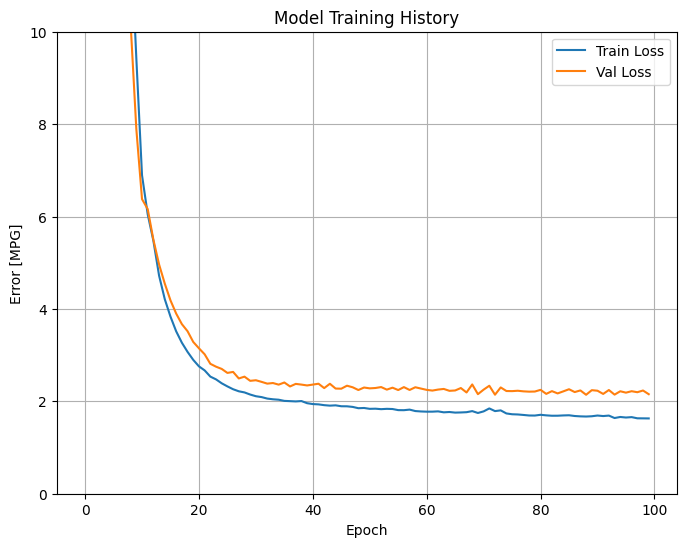

In [32]:
# 시각화
def plot_loss(history):
  plt.figure(figsize=(8, 6))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.ylim([0, 10])
  plt.title("Model Training History")
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_loss(history)

만약 Train Loss는 계속 감소하는데 Val Loss가 다시 증가하기 시작한다면 **과적합**


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


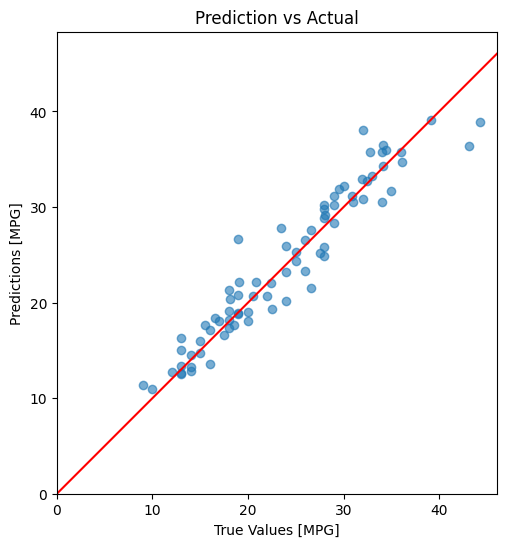

In [33]:
# 실제 예측
test_predictions = model.predict(test_features).flatten()

plt.figure(figsize=(8, 6))
plt.scatter(test_labels, test_predictions, alpha=0.6)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal') # x, y 축 비율 조정
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100], color='red') # 대각선 (완벽하게 맞춘 선)
plt.title("Prediction vs Actual")
plt.show()

텐서플로우로 간단하게 층을 2개만 쌓았는데도 꽤 정확하게 연비를 맞춤.